### Modified from the ICESat-2 data tutorial

#### original authors: Scott Henderson, Anthony Arendt, David Shean, University of Washington

In [1]:
%matplotlib inline
import os
import s3fs
import xarray as xr
import h5py
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona
import cartopy.crs as ccrs
from mpl_toolkits.mplot3d import Axes3D

In [18]:
dir(cmocean)

['__all__',
 '__authors__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'absolute_import',
 'cm',
 'data',
 'tools']

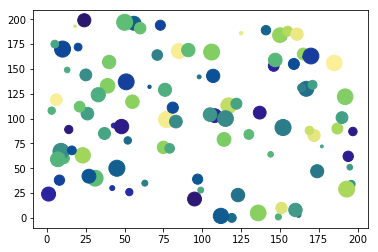

In [20]:
import random
!pip install cmocean
import cmocean

x = random.sample(range(200), 100)
y = random.sample(range(200), 100)
z = random.sample(range(200), 100)
s = [random.random()*256.+2. for i in range(100)]

fig, ax = plt.subplots()
im = ax.scatter(x, y, c=z, s=s, cmap=cmocean.cm.haline)

# ax.plot(x,y,color='k')
# ax.plot(y,x,color='r')


# [1, 6, 17, 29]
# 
# random_list(list_length, values_range)
#
# [5, 6, 22, 24]
#
# random_list(3, [0, 11])

### Initial steps are disabled via `if False` to avoid accidentally running them

In [21]:
# mount S3 as if it was a file system

if False: 
    bucket = 'pangeo-data-upload-oregon'
    fs = s3fs.S3FileSystem()

# List contents of the bucket

if False:
    dataDir = 'pangeo-data-upload-oregon/icesat2/atl06'
    s3List = fs.ls(dataDir)   
    print(s3List)

# work with the first data file

if False: 
    s3File = s3List[0]
    dataFile = format(s3File.split('/')[3])

# Download an HDF5 to home directory
# If data are in your git directory: Be sure to .gitignore .h5 files so they are not pushed to GitHub.

if False:
    fs.get(s3File, dataFile)

### Using h5py to look at the dataset structure

ICESat-2 data are structured in h5 files with multiple group levels. To find what you need it helps to view these groups. 

In [22]:
dataroot = '/home/jovyan/data/icesat2/'
datafiles = os.listdir(dataroot)
source = [dataroot + df for df in datafiles]


if False:
    datafile = source[0]
    f = h5py.File(datafile,'r')
    print(type(f), '\n\n\n')

    # HDF5 behaves like a nested dictionary or if you like as a file system containing data

    groups = list(f.keys())              # groups is a list of file keys; there are 10 including 6 for the icesat2 beams

    print("Here is the top level directory of the HDF5 file:\n")
    for g in groups: print(g)            # treated as a list of key strings: The "top level directory contents"

    print('\n\n\n')

    for g in groups:
        print('---','Group: {}'.format(g), '---')
        group = f[g]                                      # 'g' is a dictionary key. Values are a list of keys
        for d in group.keys(): print('    ', group[d])

In [23]:
if False:
    toplevel=f.keys()
    a=list(toplevel)[7]

    print('The key for ground track 3-right:')
    print('     ', a, '\n')

    b = f[a].keys()

    print('The keys for gt3r:\n', b, '\n')

    c = list(b)[0]

    print('That first key, being land_ice_segments:\n', c, '\n')

    print('the keys for land_ice_segments:')
    print(f[a][c].keys())

    d=list(f[a][c]['h_li'])[0]

    print('the first land ice height: \n', d, '\n')

    is_h = list(f[a][c]['h_li'])
    is_lat = list(f[a][c]['latitude'])
    is_lon = list(f[a][c]['longitude'])
    print(len(is_h), len(is_lat), len(is_lon))
    plt.plot(is_h)


### Enter xarray

Let's use gt3r/land_ice_segments.


There were two files that proved defective, were deleted (both small). For the record:

* `/home/jovyan/data/icesat2/ATL06_20190130075041_05020206_001_01.h5`
* `/home/jovyan/data/icesat2/ATL06_20190207073402_06240206_001_01.h5`

In [24]:
ds = xr.open_dataset(source[2],group='/gt3r/land_ice_segments')
print(ds)

<xarray.Dataset>
Dimensions:                (delta_time: 6165)
Coordinates:
  * delta_time             (delta_time) datetime64[ns] 2018-11-15T22:46:37.277305940 ... 2018-11-15T22:47:15.535761312
    latitude               (delta_time) float64 ...
    longitude              (delta_time) float64 ...
Data variables:
    atl06_quality_summary  (delta_time) int8 ...
    h_li                   (delta_time) float32 ...
    h_li_sigma             (delta_time) float32 ...
    segment_id             (delta_time) float64 ...
    sigma_geo_h            (delta_time) float32 ...
Attributes:
    Description:  The land_ice_height group contains the primary set of deriv...
    data_rate:    Data within this group are sparse.  Data values are provide...


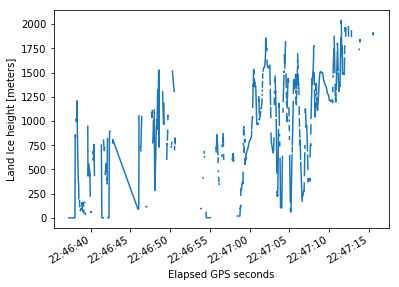

In [26]:
ds.h_li.plot()

### Convert to Pandas dataframe

In [27]:
df = ds.to_dataframe()
df.head(6)

,atl06_quality_summary,h_li,h_li_sigma,latitude,longitude,segment_id,sigma_geo_h
delta_time,,,,,,,
2018-11-15 22:46:37.277305940,0,0.516759,0.015562,57.075838,-134.292057,317136.0,0.664225
2018-11-15 22:46:37.280116040,0,0.469451,0.015947,57.076018,-134.292088,317137.0,0.583079
2018-11-15 22:46:37.282997796,0,0.439790,0.017407,57.076202,-134.292119,317138.0,0.559209
2018-11-15 22:46:37.285796296,0,0.391246,0.015143,57.076382,-134.292149,317139.0,0.452374
2018-11-15 22:46:37.288596484,0,0.351077,0.016054,57.076561,-134.292179,317140.0,0.549744
2018-11-15 22:46:37.291309648,0,0.421774,0.017310,57.076734,-134.292208,317141.0,0.433003


## Make a simple 3D scatter plot

In [28]:
if False:
    f = plt.figure()
    ax3D = f.add_subplot(111, projection='3d')
    sc = ax3D.scatter(df['latitude'], df['longitude'], df['h_li'], c=df['h_li'], marker='.')

## Convert the Pandas dataframe to a Geopandas dataframe

This mean the latitude and longitude columns are converted from just numbers into a geometry so Python knows where the data are in space.

In [29]:
df['geometry'] = list(zip(df['longitude'], df['latitude']))
df['geometry'] = df['geometry'].apply(Point)
gdf = gpd.GeoDataFrame(df)
df.head()

,atl06_quality_summary,h_li,h_li_sigma,latitude,longitude,segment_id,sigma_geo_h,geometry
delta_time,,,,,,,,
2018-11-15 22:46:37.277305940,0,0.516759,0.015562,57.075838,-134.292057,317136.0,0.664225,POINT (-134.2920568418402 57.07583842784263)
2018-11-15 22:46:37.280116040,0,0.469451,0.015947,57.076018,-134.292088,317137.0,0.583079,POINT (-134.292087720185 57.07601805728899)
2018-11-15 22:46:37.282997796,0,0.439790,0.017407,57.076202,-134.292119,317138.0,0.559209,POINT (-134.2921189793639 57.07620243069638)
2018-11-15 22:46:37.285796296,0,0.391246,0.015143,57.076382,-134.292149,317139.0,0.452374,POINT (-134.2921490735631 57.07638150470106)
2018-11-15 22:46:37.288596484,0,0.351077,0.016054,57.076561,-134.292179,317140.0,0.549744,POINT (-134.2921790745613 57.07656058416076)


In [44]:
df.shape

(44780, 8)

### make a simple map

* get a geojson file with US state polygons
* use Cartopy to make a very simple map

In [30]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

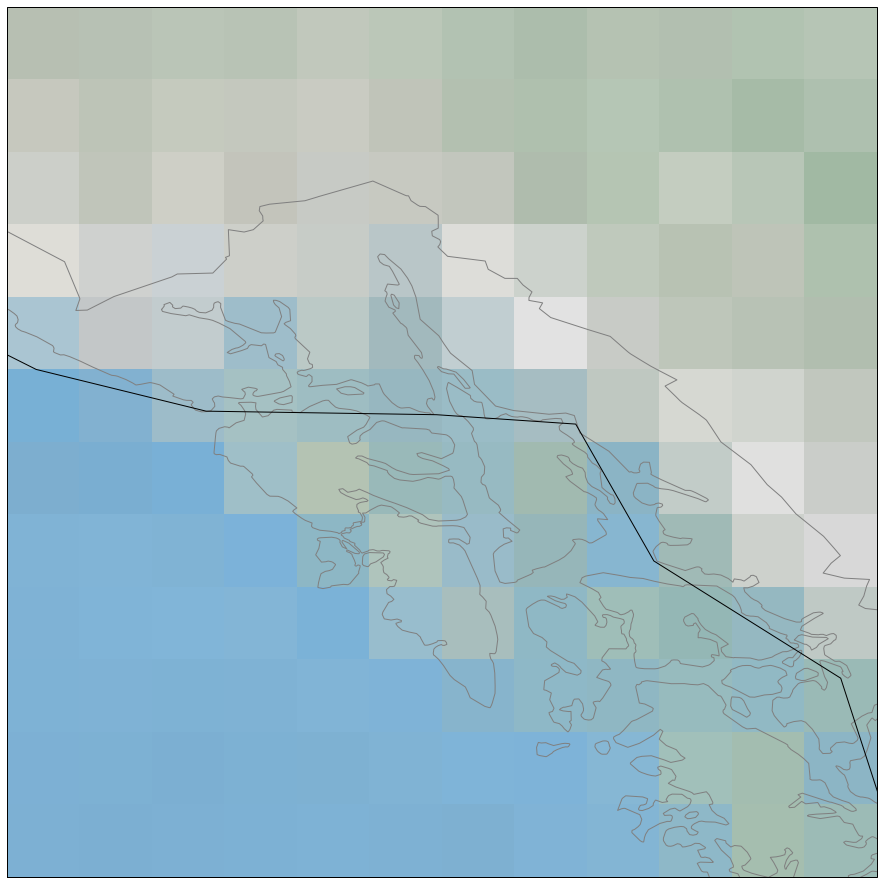

In [45]:
fig = plt.figure(figsize=(16, 16))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-138,-132, 55, 61])
ax.stock_img()
states_gdf.plot(ax=ax, facecolor='none', edgecolor='gray')
gdf.plot(ax=ax, column='h_li', markersize=.5) # experiment with column='h_li' versus color='k' versus cmap=
ax.coastlines()

KeyboardInterrupt: 

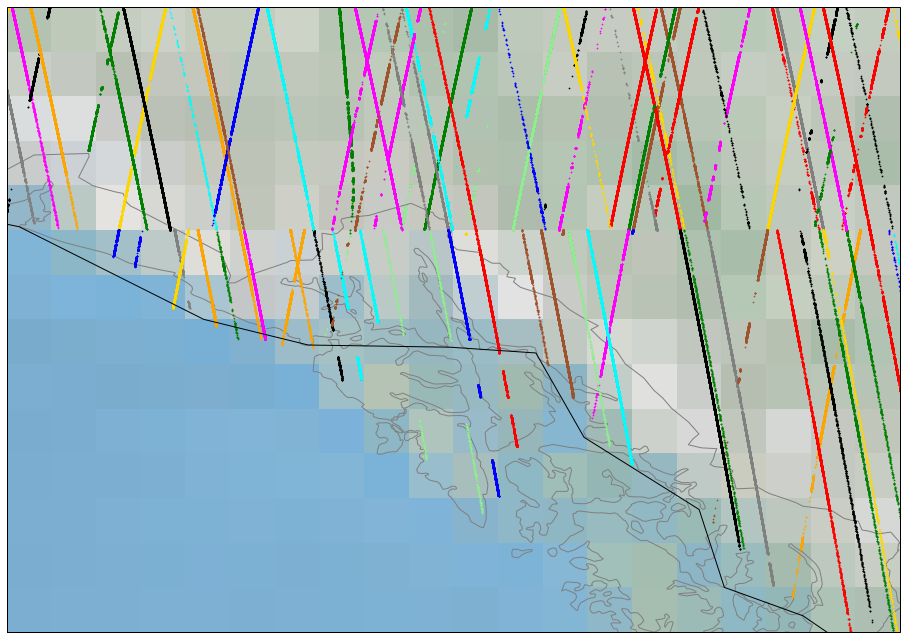

In [32]:
%%time

# create a geopandas data frame from state outlines for some added map context; particularly coastline
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

fig = plt.figure(figsize=(16, 16))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-140,-130, 55, 62])
ax.stock_img()
states_gdf.plot(ax=ax, facecolor='none', edgecolor='gray')
ax.coastlines()

c=['sienna', 'gold', 'red', 'orange', 'lightgreen', 'green', 'cyan', 'blue', 'fuchsia', 'grey', 'black']
nc = len(c)

fi0 = 0
fi1 = len(source)
for i in range(fi0, fi1):
    # print(i, source[i])
    ds = xr.open_dataset(source[i],group='/gt3r/land_ice_segments')
    df = ds.to_dataframe()
    df['geometry'] = list(zip(df['longitude'], df['latitude']))
    df['geometry'] = df['geometry'].apply(Point)
    gdf = gpd.GeoDataFrame(df)
    gdf.plot(ax=ax, color=c[i%nc], markersize=.5)    # see original for column/cmap combo to color
    ds.close()


In [14]:
if False:
    for i in range(5):
        ds = xr.open_dataset(source[i],group='/gt3r/land_ice_segments')
        print(ds.latitude[0:3].values, ds.latitude[-3:].values)

In [15]:
if False: 
    fi0 = 0
    fi1 = len(source)
    jiftrax = []
    for i in range(fi0, fi1):
        ds = xr.open_dataset(source[i],group='/gt3r/land_ice_segments')
        if ds.latitude[0].values < 59.6 and ds.latitude[-1].values < 59.6:
            if ds.longitude[0] > -136.:
                if ds.longitude[0] < -133.5:
                    jiftrax.append(i)
    print(jiftrax)

In [46]:
# all: jiftrax = [1, 2, 4, 33, 44, 51, 70, 94, 99, 117, 134, 143, 158, 161, 165, 192, 204, 206, 207, 210]
jiftrax = [2, 44, 51, 70, 99, 134, 143, 158, 204, 206]

# create a geopandas data frame from state outlines for some added map context; particularly coastline
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

# c=['red', 'orange', 'chocolate', 'lightgreen', 'green', 'cyan', 'lightblue', 'blue', 'magenta', 'white', 'black']
# nc = len(c)

ds = xr.open_dataset(source[2], group='/gt3r/land_ice_segments')
y=ds.latitude.values
x=ds.longitude.values
h=ds.h_li.values

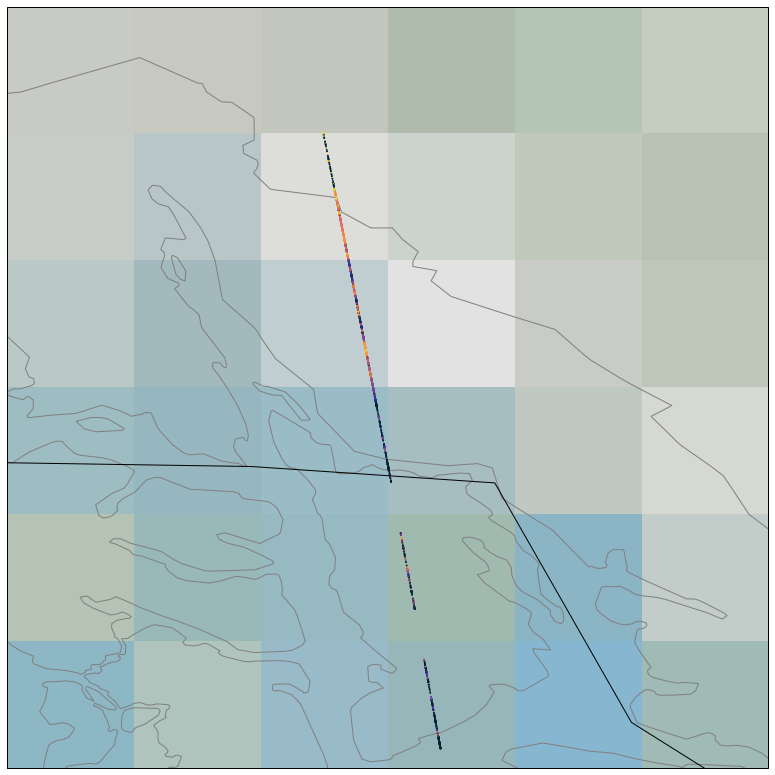

In [89]:
# background plot
fig = plt.figure(figsize=(14, 14))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-136,-133, 57, 60])
ax.stock_img()
states_gdf.plot(ax=ax, facecolor='none', edgecolor='gray')
ax.coastlines()
gdf.plot(ax=ax, column='h_li', markersize=.5, cmap=cmocean.cm.thermal)
# data
# ax.plot(x,y)
# ds = xr.open_dataset(source[2], group='/gt3r/land_ice_segments')
# df = ds.to_dataframe()
# df['geometry'] = list(zip(df['longitude'], df['latitude']))
# df['geometry'] = df['geometry'].apply(Point)
# gdf = gpd.GeoDataFrame(df)
# gdf.plot(ax=ax, column='latitude', markersize=36)
# x = gdf.longitude.values
# y = gdf.latitude.values
# c = gdf.h_li.values
# ax.plot(x, y, c=c, markersize=1)

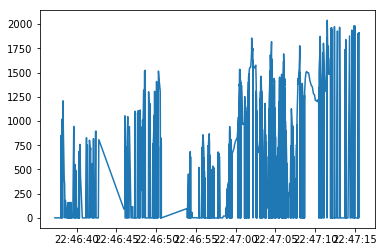

In [87]:
plt.plot(gdf.h_li)

In [78]:
nz = 0
for i in range(len(gdf)):
    if np.isnan(gdf.h_li[i]): 
        gdf.h_li[i] = 0.
        nz = nz + 1
print(nz)

0


In [82]:
import numpy as np
c = gdf.h_li.values
print('hello')
for i in range(len(c)):
    if c[i] < 0: print(i, c[i])
    if c[i] > 3000: print(i, c[i])
    if np.isnan(c[i]): print(i, c[i])

hello


In [ ]:
df = ds.to_dataframe()
df['geometry'] = list(zip(df['longitude'], df['latitude']))
df['geometry'] = df['geometry'].apply(Point)
gdf = gpd.GeoDataFrame(df)
x = gdf.longitude.values
y = gdf.latitude.values
c = gdf.h_li.values
ax.plot(x, y, c=c, markersize=1)

if False:
    # for i in range(len(jiftrax)):
    for i in range(1):
        j = jiftrax[i]
        print(j, source[j])
        ds = xr.open_dataset(source[j],group='/gt3r/land_ice_segments')
        df = ds.to_dataframe()
        df['geometry'] = list(zip(df['longitude'], df['latitude']))
        df['geometry'] = df['geometry'].apply(Point)
        gdf = gpd.GeoDataFrame(df)
        # gdf.plot(ax=ax, color=c[i%nc], markersize=.5)    # see original for column/cmap combo to color
        gdf.plot(ax=ax, c=gdf.h_li.values, markersize=.5)    # see original for column/cmap combo to color; clim=[a,b] also possible
        ds.close()

In [ ]:
type(gdf.h_li)

In [ ]:
# dir(gdf.h_li)

In [ ]:
gdf.h_li.values

In [ ]:
plt.plot(gdf.h_li.values)

In [ ]:
gdf.latitude.values

In [ ]:
gdf.longitude.values